### b)
- Há tendência estocástica, visto que os valores não se seguem de forma linear. Usando como base a série padrão, não é possível ver sazonalidade. 
Porém, usando a decomposição com média móvel de 30 dias é possível perceber repetições padronizadas

### c)
- Visto que no gráfico de ACF de ambas há um decrescimento gradual e PACF decrescimento abrupto. Há indício que a série é AR(1) 
com alta chance de possuir raiz unitária e não estacionalidade.

### h)
- Apesar de um leve acréscimo no R Ajustado e AIC saindo do modelo ADL (1,1) para ADL (2,2) não seria um aumento relevante.

### i)
- Visto que no summary P>|t| dos minérios são maiores que 0.05. Logo, pouco significativos. Então, não há como afirmar dentro
da amostra que o preço do minério é significante para ADR da Vale.

In [1]:
import pandas as pd
import matplotlib.pyplot as graph
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, coint
from statsmodels.tsa.arima.model import ARIMA

In [2]:
raw_dataset = pd.read_excel('datasets/vale_occam2020.xlsx')
range_dataset = raw_dataset.iloc[:-24]

In [3]:
graph.rcParams['figure.figsize'] = (30, 6)
graph.style.use('grayscale')

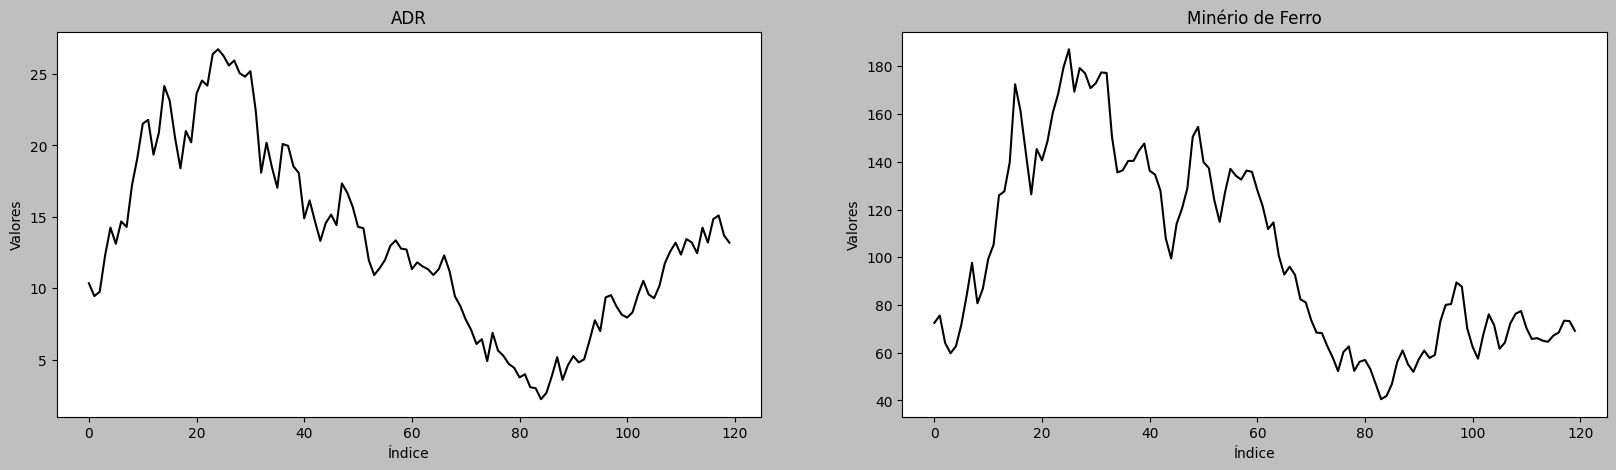

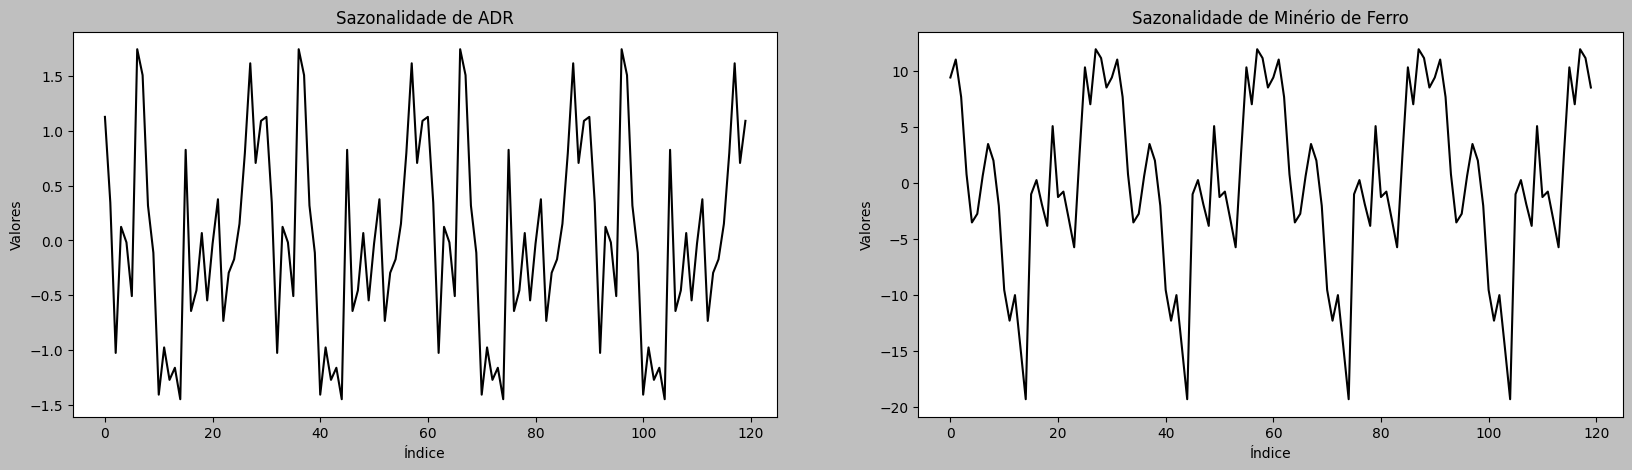

In [4]:
range_dataset.head()
adr = pd.Series(data=range_dataset['vale_adr'])
iron_ore = pd.Series(data=range_dataset['iron_ore'])
fig, axs = graph.subplots(1, 2, figsize=(20, 5))

axs[0].plot(adr)
axs[0].set_title('ADR')
axs[0].set_xlabel('Índice')
axs[0].set_ylabel('Valores')

axs[1].plot(iron_ore)
axs[1].set_title('Minério de Ferro')
axs[1].set_xlabel('Índice')
axs[1].set_ylabel('Valores')

graph.show()

adr_decompose = seasonal_decompose(adr, period=30)
iron_ore_decompose = seasonal_decompose(iron_ore, period=30)

fig, axs_decompose = graph.subplots(1, 2, figsize=(20, 5))

axs_decompose[0].plot(adr_decompose.seasonal)
axs_decompose[0].set_title('Sazonalidade de ADR')
axs_decompose[0].set_xlabel('Índice')
axs_decompose[0].set_ylabel('Valores')

axs_decompose[1].plot(iron_ore_decompose.seasonal)
axs_decompose[1].set_title('Sazonalidade de Minério de Ferro')
axs_decompose[1].set_xlabel('Índice')
axs_decompose[1].set_ylabel('Valores')

graph.show()

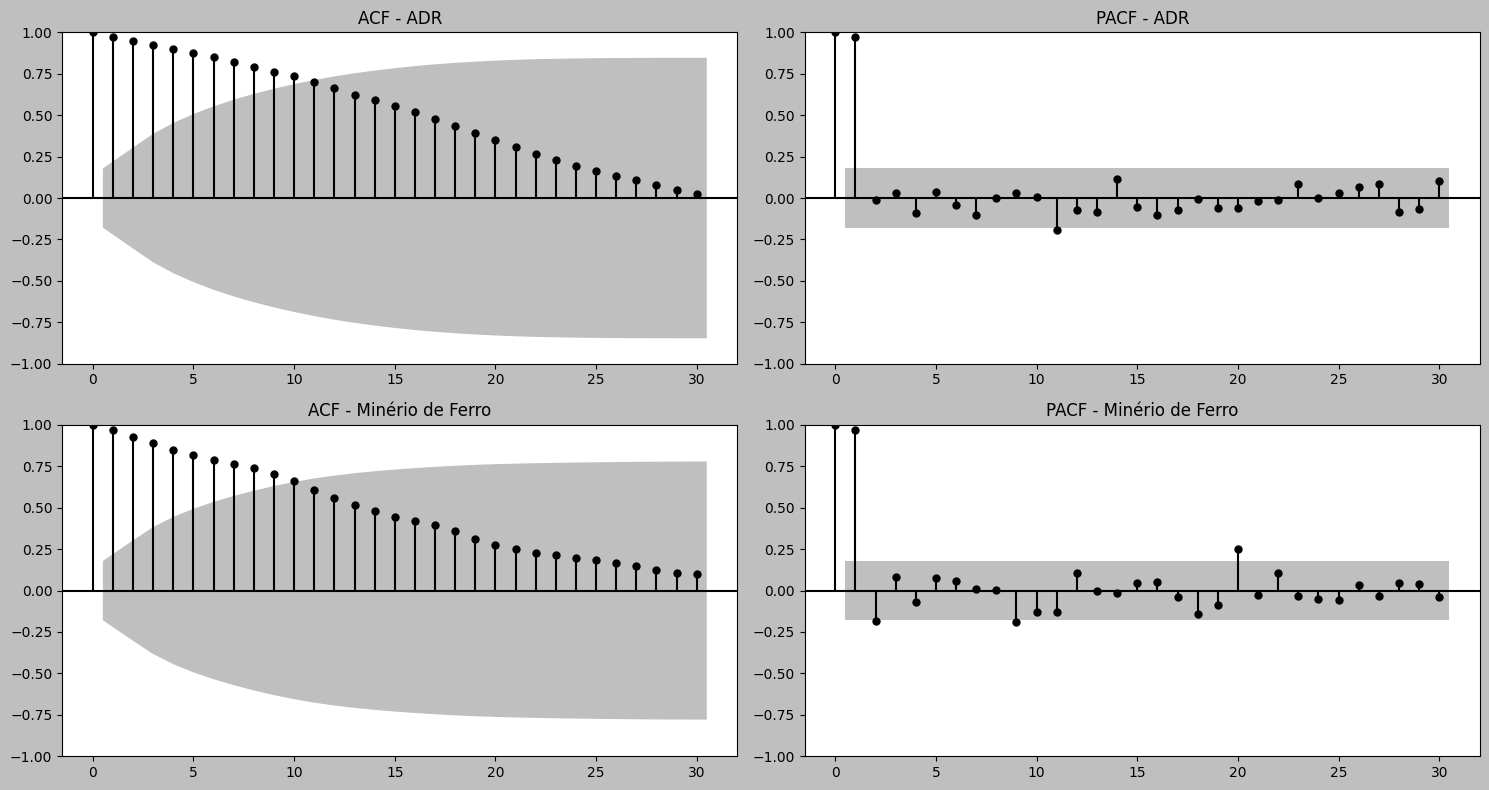

In [5]:
fig, axs = graph.subplots(2, 2, figsize=(15, 8))

plot_acf(adr, lags=30, title='ACF - ADR', ax=axs[0, 0])
plot_pacf(adr, lags=30, title='PACF - ADR', ax=axs[0, 1])

plot_acf(iron_ore, lags=30, title='ACF - Minério de Ferro', ax=axs[1, 0])
plot_pacf(iron_ore, lags=30, title='PACF - Minério de Ferro', ax=axs[1, 1])

graph.tight_layout()
graph.show()

In [6]:
def adf_test(series, title):
    result = adfuller(series)
    p_value = result[1]
    if p_value <= 0.05:
        return f'A série {title} É estacionária. P-Valor: {p_value}'
    return f'A série {title} NÃO é estacionária. P-Valor: {p_value}'

print(adf_test(adr, 'ADR'))
print(adf_test(iron_ore, 'Minério de Ferro'))

A série ADR NÃO é estacionária. P-Valor: 0.6525945915335669
A série Minério de Ferro NÃO é estacionária. P-Valor: 0.5336745705144721


In [7]:
def get_resid_base_forecast(p,d,q, series):
    model = ARIMA(series, order=(p, d, q))
    result = model.fit()
    forecasting_result = result.forecast(1)
    return {'resid': result.resid, 'result': result, 'forecast': forecasting_result.iloc[-1]}

def choose_model(series : pd.Series, models):
    for item in models:
        p, d, q = item['p'], item['d'], item['q']
        base_result = get_resid_base_forecast(p=p,d=d,q=q,series=series)
        resid_result = get_resid_base_forecast(p=p,d=d,q=q,series= base_result['resid'])

        print(f'Modelo({p},{d},{q}) \n Previsão do Resultado: {base_result['forecast']} \n Previsão do Erro da Previsão: {resid_result['forecast']} \n')

choose_model(series=adr, models=[
    {'p': 1, 'd': 1, 'q': 0},
    {'p': 0, 'd': 1, 'q': 1},
    {'p': 2, 'd': 1, 'q': 0},
    {'p': 1, 'd': 1, 'q': 1},
    ])

Modelo(1,1,0) 
 Previsão do Resultado: 13.195973057698142 
 Previsão do Erro da Previsão: -0.9647416837281784 

Modelo(0,1,1) 
 Previsão do Resultado: 13.196709397678223 
 Previsão do Erro da Previsão: 0.126772463363775 

Modelo(2,1,0) 
 Previsão do Resultado: 13.25389636747804 
 Previsão do Erro da Previsão: -0.38622391353672736 

Modelo(1,1,1) 
 Previsão do Resultado: 13.201498225441915 
 Previsão do Erro da Previsão: 0.20352781779350126 



c:\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [8]:
raw_dataset['1lag_iron_ore'] = np.log(raw_dataset['iron_ore'].shift(1))
raw_dataset['1lag_dja'] = np.log(raw_dataset['DJA'].shift(1))

raw_dataset['ln_vale_adr'] = np.log(raw_dataset['vale_adr'])

raw_dataset = raw_dataset.dropna()

x = raw_dataset[['1lag_iron_ore','1lag_dja']]
y = raw_dataset['ln_vale_adr']

raw_dataset.to_csv('datasets/dataset3.csv')

In [9]:
df = pd.read_csv('datasets/dataset3.csv')
df = df.dropna()

model_static = sm.OLS(df['ln_vale_adr'], sm.add_constant(df[['1lag_iron_ore', '1lag_dja']])).fit()
#print(model_static.summary())

df['ln_vale_adr_lag1'] = df['ln_vale_adr'].shift(1)
df = df.dropna()
model_adl = sm.OLS(df['ln_vale_adr'], sm.add_constant(df[['ln_vale_adr_lag1', '1lag_iron_ore', '1lag_dja']])).fit()
print(model_adl.summary())

                            OLS Regression Results                            
Dep. Variable:            ln_vale_adr   R-squared:                       0.944
Model:                            OLS   Adj. R-squared:                  0.943
Method:                 Least Squares   F-statistic:                     774.6
Date:                Wed, 29 Nov 2023   Prob (F-statistic):           1.09e-85
Time:                        18:17:50   Log-Likelihood:                 94.934
No. Observations:                 141   AIC:                            -181.9
Df Residuals:                     137   BIC:                            -170.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.7030      0.383  

In [10]:
last_observation = df.iloc[-1][['1lag_iron_ore', '1lag_dja', 'ln_vale_adr_lag1']]

predicted_static = model_static.predict([1] + last_observation[['1lag_iron_ore', '1lag_dja']].tolist())
predicted_adl = model_adl.predict([1] + last_observation.tolist())

print(f'Previsão do Modelo Estático: {predicted_static}')
print(f'Previsão do Modelo ADL (1,1): {predicted_adl}')

Previsão do Modelo Estático: [2.61508727]
Previsão do Modelo ADL (1,1): [4.89861673]


In [11]:
df['ln_vale_adr_lag1'] = df['ln_vale_adr'].shift(1)
df['ln_vale_adr_lag2'] = df['ln_vale_adr'].shift(2)
df['1lag_iron_ore_lag1'] = df['1lag_iron_ore'].shift(1)
df['1lag_iron_ore_lag2'] = df['1lag_iron_ore'].shift(2)
df['1lag_dja_lag1'] = df['1lag_dja'].shift(1)
df['1lag_dja_lag2'] = df['1lag_dja'].shift(2)

df = df.dropna()
model_adl_2_2 = sm.OLS(df['ln_vale_adr'], sm.add_constant(df[['ln_vale_adr_lag1', 'ln_vale_adr_lag2', '1lag_iron_ore_lag1', '1lag_iron_ore_lag2', '1lag_dja_lag1', '1lag_dja_lag2']])).fit()

print(model_adl_2_2.summary())

                            OLS Regression Results                            
Dep. Variable:            ln_vale_adr   R-squared:                       0.946
Model:                            OLS   Adj. R-squared:                  0.943
Method:                 Least Squares   F-statistic:                     384.9
Date:                Wed, 29 Nov 2023   Prob (F-statistic):           4.84e-81
Time:                        18:17:50   Log-Likelihood:                 94.682
No. Observations:                 139   AIC:                            -175.4
Df Residuals:                     132   BIC:                            -154.8
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.7336      0

In [12]:
last_observation_adl_2_2 = df.iloc[-1][['ln_vale_adr_lag1', 'ln_vale_adr_lag2', '1lag_iron_ore_lag1', '1lag_iron_ore_lag2', '1lag_dja_lag1', '1lag_dja_lag2']]

last_observation_adl_2_2 = [1] + last_observation_adl_2_2.tolist()
predicted_adl_2_2 = model_adl_2_2.predict(last_observation_adl_2_2)

print(f'Previsão do Modelo ADL (2,2): {predicted_adl_2_2}')

Previsão do Modelo ADL (2,2): [2.32444444]


In [13]:
result = coint(df['vale_adr'], df['iron_ore'])

print(f'Estatística do Teste: {result[0]}')
print(f'P-Valor: {result[1]}')

"""
Como p-valor é maior que 0.05 não há evidências para rejeitar a hipotese nula de não integração.

"""

Estatística do Teste: -2.1452750479725538
P-Valor: 0.45273687683718805


'\nComo p-valor é maior que 0.05 não há evidências para rejeitar a hipotese nula de não integração.\n\n'